Введение
(обязательно к просмотру)

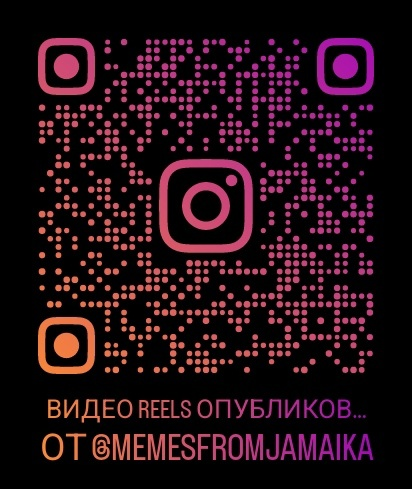

In [ ]:
from IPython.display import Image
Image("123.jpg", width=412, height=489)

1.Напишем основные функции, которые переведут json в таблицу
read_json - чтение json'а и запись в словарь
search_unique_ingredients - создание массива уникальных ингридиентов
create_dataframe - создание датафрейма из словаря с применением One Hot Encoder

In [ ]:
import json
import numpy as np
import pandas as pd


def read_json(path: str) -> list:
    with open(path) as f:
        return json.load(f)


def search_unique_ingredients(data: list) -> np.array:
    ret = []
    for obj in data:
        for ing in obj['ingredients']:
            ret.append(ing)
    return np.unique(ret)


def create_dataframe(data: list, unique_ingredients: np.array) -> pd.DataFrame:
    cols = np.append(unique_ingredients, 'cuisine')
    df = pd.DataFrame(index=[_['id'] for _ in data], columns=cols)
    for obj in data:
        id = obj['id']
        df.loc[df.index == id, 'cuisine'] = obj['cuisine']
        for ing in obj['ingredients']:
            df.loc[df.index == id, ing] = True
    return df.fillna(value=False)


def json_to_dataframe(path):
    data = read_json(path)
    unique_ingredients = search_unique_ingredients(data)
    return create_dataframe(data, unique_ingredients)

2.Посмотрим полученный датафрейм

In [ ]:
df = json_to_dataframe('data.json')
df.head()

,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms,cuisine
10259,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,greek
25693,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,southern_us
20130,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,filipino
22213,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,indian
13162,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,indian


3.Выведем основную статистистику по нему

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39774 entries, 10259 to 2362
Columns: 6715 entries, (    oz.) tomato sauce to cuisine
dtypes: bool(6714), object(1)
memory usage: 255.3+ MB


4.Создадим массив уникальных кухонь и посмотрим, какие игридиенты самые популярные внутри одной кухни
(он так долго считался, что гугл колаб вылетел :_) но код точно работает, проверяла на маленькой части датафрейма

In [ ]:
cuisines = np.unique(df['cuisine'])
most_popular_ing_by_cuisine = {}
for cuisine in cuisines:
  tmp_dict = {}
  for col in df.columns[:-1]:
    tmp_dict[col] = df[df['cuisine'] == cuisine][col].sum()
  most_popular_ing_by_cuisine[cuisine] = max(tmp_dict, key=tmp_dict.get)
print(most_popular_ing_by_cuisine)

KeyboardInterrupt: ignored

5.Посмотрим, насколько часто встречается та или иная кухня в данных

In [ ]:
print(df['cuisine'].value_counts())

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64


6. Проиллюстрируем полученные результаты

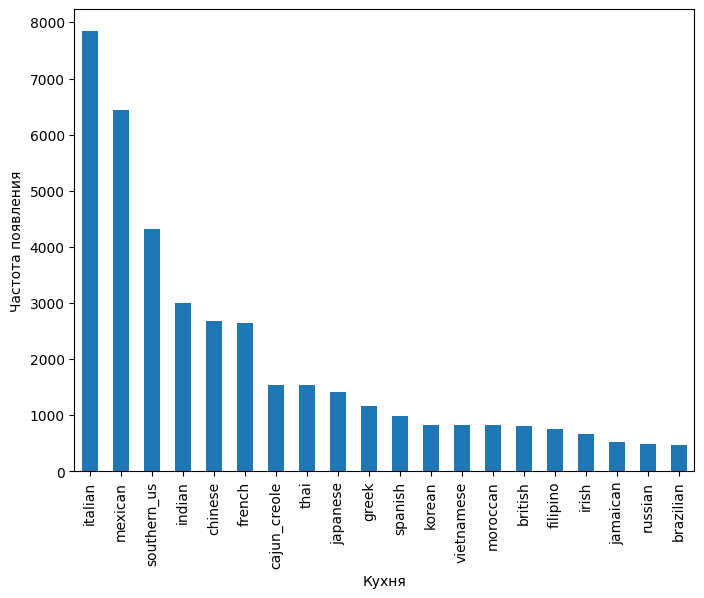

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df['cuisine'].value_counts().plot(kind='bar')
plt.xlabel('Кухня')
plt.ylabel('Частота появления')
plt.show()

7. Поскольку количество кухонь отличается на порядок (например бразильской всего 467 рецептов), то воспользуемся методом, позволяющим разбить данные на трейн и тест так, что частота вхождения каждой кухни в тестовую и тренировочную выборку одинаковые
Это нужно, чтобы избежать случая, когда, например бразильская кухня не попадет в обучающую выборку, а только в тестовую

In [ ]:
df.reset_index(drop=True, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit

X = df.drop('cuisine', axis=1)
y = df['cuisine']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=1281283)

for train_index, test_index in sss.split(X, y):
  X_train = df.loc[train_index].drop('cuisine', axis=1)
  X_test = df.loc[test_index].drop('cuisine', axis=1)
  y_train = (df.loc[train_index])['cuisine']
  y_test = (df.loc[test_index])['cuisine']


print(y_train.value_counts())
print(y_test.value_counts())

italian         2351
mexican         1931
southern_us     1296
indian           901
chinese          802
french           794
cajun_creole     464
thai             462
japanese         427
greek            352
spanish          297
korean           249
vietnamese       247
moroccan         246
british          241
filipino         227
irish            200
jamaican         158
russian          147
brazilian        140
Name: cuisine, dtype: int64
italian         5487
mexican         4507
southern_us     3024
indian          2102
chinese         1871
french          1852
cajun_creole    1082
thai            1077
japanese         996
greek            823
spanish          692
korean           581
vietnamese       578
moroccan         575
british          563
filipino         528
irish            467
jamaican         368
russian          342
brazilian        327
Name: cuisine, dtype: int64


8.В гугл колабе всего 12 гб оперативы, все не влезает, поэтому пришлось удалить оригинальные данные (помянем)

In [ ]:
del df

9.Посмотрим, как ведет себя логистическая регрессия

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
lg = LogisticRegression(solver='lbfgs', max_iter=200)
lg.fit(X_train, y_train)
predictions = lg.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7416


10. Попробуем улучшить точность с помощью поиска оптимальных параметров обучения и применим кросс валидацию: обучающая выборка разбивается на несколько частей, в данном случае 3, и сначала обучается на частях 1 и 2, потом проверяется на 3, обучается на 1 и 3, проверяется на 2, обучается на 2 и 3, проверяется на 1, кроме этого попробуем поменять одну из заданных констант обучения

In [ ]:
from sklearn.model_selection import GridSearchCV

grid = {'C': np.logspace(-2,2,7)}
# C and penalty are logistic regression regularization parameters
# If C is too small model is underfitted, if C is too big model is overfitted.
# l1 and l2 are regularization loss functions (l1=lasso, l2=ridge)

# Creating the model:
lr = LogisticRegression(solver='lbfgs', max_iter=200)

# Creating GridSearchCV model:
lr_cv = GridSearchCV(lr, grid, cv=3) # Using lr model, grid parameters and cross validation of 10 (10 times of accuracy calculation will be applied)

# Training the model:
lr_cv.fit(X_train, y_train)

print('best paremeters for logistic regression: ', lr_cv.best_params_)
print('best score for logistic regression after grid search cv:', lr_cv.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

best paremeters for logistic regression:  {'C': 1.0}
best score for logistic regression after grid search cv: 0.7288805006194702


11.Как можно видеть, лучше не стало
попробуем применить другие солверы

In [ ]:
lr_sag = LogisticRegression(solver='sag', max_iter=200)
lr_sag.fit(X_train, y_train)
predictions = lr_sag.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy sag: {accuracy:.4f}")

Accuracy sag: 0.7416


In [ ]:
lr_newton = LogisticRegression(solver='newton-cg', max_iter=200)
lr_newton.fit(X_train, y_train)
predictions = lr_newton.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy sag: {accuracy:.4f}")

Accuracy sag: 0.7416


12. Это тоже не дало никаких результатов, попробуем другой метод обучения - случайный лес
лучшая точность логистической регрессии: 0.7416

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy RF: {accuracy:.4f}")

Accuracy RF: 0.6738


13. Точность тоже низка, снова попробуем поиск по сетке параметро и кросс-валидацию

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [100, 150, 200, 250]
max_features = ['log2', 'sqrt']
max_depth = [3, 18, 32]
min_samples_split = [2, 15, 28]
min_samples_leaf = [2, 15, 28]
bootstrap = [True, False]
rfc_2 = RandomForestClassifier()
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
rs = RandomizedSearchCV(rfc_2,
                        param_dist,
                        n_iter = 100,
                        cv = 3,
                        verbose = 1,
                        n_jobs=-1,
                        random_state=0)
rs.fit(X_train, y_train)
print(rs.best_params_)
print(f"Accuracy RF: {accuracy_score(y_test, rfc.predict(X_test)):.4f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'n_estimators': 200, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 32, 'bootstrap': False}
Accuracy RF: 0.6738


In [ ]:
print(f"Accuracy RF: {accuracy_score(y_test, rs.predict(X_test)):.4f}")

Accuracy RF: 0.5662


14. В итоге точность стала хуже, поэтому оставляем оригинальные настройки модели
лучшая точность у леса: 0.6738

15. Поплачем, затем попробуем метод градиентного спуска

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Создание модели Gradient Boosting для бинарной классификации
gradient_boosted = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)


# Fit the model on the training data
gradient_boosted.fit(X_train, y_train)

# Make predictions on the test data
predictions = gradient_boosted.predict(X_test)

print(f"Accuracy GB: {accuracy_score(y_test, predictions):.4f}")

Accuracy GB: 0.6798


In [ ]:
model = GradientBoostingClassifier()

# Определение сетки гиперпараметров
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Поиск наилучших гиперпараметров
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_



15. К сожалению, он слишком долго обучается и не вывел никаких результатов
таким образом точность градиентого спуска 0.6798

Заключение
Таким образом были рассмотрены 3 метода обучения с следующими точностями:
логистическая регрессия - 0.7416
градиентный спуск - 0.6798
случайный лес - 0.6738

Также изучено, как работает кросс-валидация и метод one hot encoder, особенно его главный минус: нехватка оперативной памяти.